## loading data

The goal of the project is to recommend similar movies given a list of movies.


In [40]:
import numpy as np
import pandas as pd 

In [41]:
ratings = pd.read_csv('./title.ratings.tsv', sep='\t')
basics = pd.read_csv('./title.basics.tsv', sep = '\t')

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_62318/3766811122.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv('./title.basics.tsv', sep = '\t')


In [42]:
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


## transform and clean data

In [43]:
# get_dummies does not work so well with column of lists
# so I am using my self-defined functions here to encode
# genres into numerical values
genres = {}
def genre_tolist(genre):
    if genre:
        genre = str(genre)
        genre = genre.lower()
        genre = genre.split(',')
        for x in genre:
            if x not in genres:
                genres[x] = 1
            else:
                genres[x] += 1
    return genre

basics['genres'] = basics['genres'].apply(genre_tolist)
basics = basics[~basics.genres.isin(['\\n'])]
basics = basics[~basics.genres.isin(['nan'])]
del genres['\\n']
del genres['nan']

genres_copy = genres.copy()
for x in genres_copy:
    genres_copy[x] = []

for index, row in basics.iterrows():
    current = row['genres']
    for key in genres_copy:
        if key in current:
            genres_copy[key].append(1)
        else:
            genres_copy[key].append(0)

for key in genres_copy:
    basics[key] = genres_copy[key]
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,documentary,...,history,mystery,sci-fi,musical,thriller,film-noir,talk-show,game-show,reality-tv,adult
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"[documentary, short]",1,...,0,0,0,0,0,0,0,0,0,0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"[animation, short]",0,...,0,0,0,0,0,0,0,0,0,0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"[animation, comedy, romance]",0,...,0,0,0,0,0,0,0,0,0,0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"[animation, short]",0,...,0,0,0,0,0,0,0,0,0,0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"[comedy, short]",0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
basics.isna().sum()

tconst             0
titleType          0
primaryTitle      11
originalTitle     11
isAdult            0
startYear          0
endYear            0
runtimeMinutes     0
genres             0
documentary        0
short              0
animation          0
comedy             0
romance            0
sport              0
news               0
drama              0
fantasy            0
horror             0
biography          0
music              0
war                0
crime              0
western            0
family             0
adventure          0
action             0
history            0
mystery            0
sci-fi             0
musical            0
thriller           0
film-noir          0
talk-show          0
game-show          0
reality-tv         0
adult              0
dtype: int64

In [45]:
# We drop some columns from basics.
# It looks `titleType`, `originalTitle`, `endYear` are not informative
# either due to lack of info or info redundancy.
# So we create a sub dataframe by dropping these columns.
# We also drop the original `genres` column
# since we now have our matrix representation of it.
# since `runtimeMinutes` is kind of covered by 
# whether the genre includes `short` or not
# we are gonna ignore it as well

basics.dropna()
basics_archive = basics.copy()
basics = basics.drop(['titleType', 'originalTitle', 'endYear', 'genres', 'runtimeMinutes'], axis = 1)

In [46]:
basics.head()

,tconst,primaryTitle,isAdult,startYear,documentary,short,animation,comedy,romance,sport,...,history,mystery,sci-fi,musical,thriller,film-noir,talk-show,game-show,reality-tv,adult
0,tt0000001,Carmencita,0,1894,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0000002,Le clown et ses chiens,0,1892,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0000003,Pauvre Pierrot,0,1892,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0000004,Un bon bock,0,1892,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0000005,Blacksmith Scene,0,1893,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
ratings.isna().sum()

tconst           0
averageRating    0
numVotes         0
dtype: int64

In [48]:
Q1 = ratings.quantile(0.1)
Q3 = ratings.quantile(0.75)
Q1

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_62318/4161787400.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = ratings.quantile(0.1)
/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_62318/4161787400.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = ratings.quantile(0.75)


averageRating    5.1
numVotes         7.0
Name: 0.1, dtype: float64

In [49]:
# when number of votes is too low, there is in general no control over the ratings
# so we delete records that have < 7 votes

ratings = ratings.drop(ratings[(ratings['numVotes'] < 7)].index)

In [50]:
basics = basics.merge(ratings, on = 'tconst')

In [51]:
#  convert the year value (string) to integer for easy scaling and comparison
basics = basics[(basics['startYear']!='\\N')]
basics['startYear'] = basics['startYear'].astype(int)
basics['isAdult'] = basics['isAdult'].astype(int)

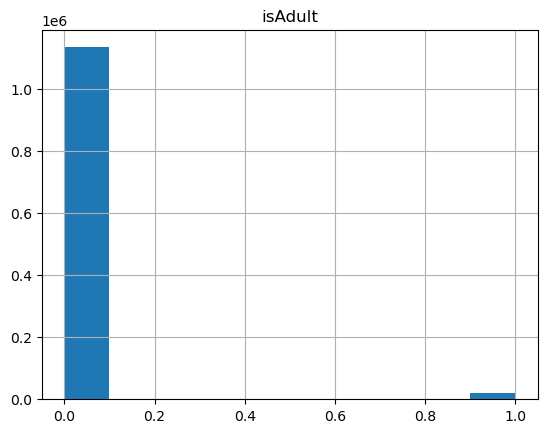

In [52]:
hist = basics.hist(column = 'isAdult')

In [53]:
# It looks adult movies are covered by the adult genre. We drop the isAdult column.
basics = basics.drop(['isAdult'], axis = 1)

In [54]:
# We can now set the ‘titleid and title’ 
# as the index and the rest of the numerical 
# features become the attributes of each unique title.
numerical = basics
numerical.index = numerical['tconst']
numerical.drop(['tconst','primaryTitle', 'tconst'],axis=1,inplace=True)
numerical.head()

,startYear,documentary,short,animation,comedy,romance,sport,news,drama,fantasy,...,sci-fi,musical,thriller,film-noir,talk-show,game-show,reality-tv,adult,averageRating,numVotes
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000001,1894,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.7,1883
tt0000002,1892,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.9,250
tt0000003,1892,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,6.5,1667
tt0000004,1892,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.8,163
tt0000005,1893,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.2,2490


In [55]:
# Data Scaling – We need to standardize the scaling of the numerical columns 
# in order to use any distance based analytical methods so that we can 
# compare the relative distances between different feature columns. We can 
# use minmaxscaler to transform the numerical columns so that they also 
# fall between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(numerical))
df.columns = numerical.columns
df.index = numerical.index
df.head()

,startYear,documentary,short,animation,comedy,romance,sport,news,drama,fantasy,...,sci-fi,musical,thriller,film-noir,talk-show,game-show,reality-tv,adult,averageRating,numVotes
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000001,0.135135,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522222,0.000724
tt0000002,0.121622,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.544444,0.000094
tt0000003,0.121622,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.611111,0.000640
tt0000004,0.121622,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.000060
tt0000005,0.128378,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577778,0.000958


In [56]:
# rating and number of votes are important
# so we give them more weight
rating_weight = 3
numvote_weight = 3
df = df.assign(weighted_rating = lambda x : (x['averageRating'] * rating_weight))
df = df.assign(weighted_vote = lambda x : (x['numVotes'] * numvote_weight))

In [57]:
df.head()

,startYear,documentary,short,animation,comedy,romance,sport,news,drama,fantasy,...,thriller,film-noir,talk-show,game-show,reality-tv,adult,averageRating,numVotes,weighted_rating,weighted_vote
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000001,0.135135,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.522222,0.000724,1.566667,0.002171
tt0000002,0.121622,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.544444,0.000094,1.633333,0.000281
tt0000003,0.121622,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.611111,0.000640,1.833333,0.001921
tt0000004,0.121622,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.000060,1.600000,0.000180
tt0000005,0.128378,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.577778,0.000958,1.733333,0.002873


## do cosine similarity

In [58]:
from numpy import dot
from numpy.linalg import norm 
def cosine_sim(v1,v2):
    '''
    Calculates the cosine similarity between two vectors
    '''
    return dot(v1,v2)/(norm(v1)*norm(v2))

In [60]:
def getInputVec(idx_list):
    s = df.loc[idx_list[0]].values
    for i in range(1,len(idx_list)):
        s += df.loc[idx_list[i]].values
    return [x/len(idx_list) for x in s]

In [75]:
basics_plain = pd.read_csv('./title.basics.tsv', sep = '\t')
basics_plain = basics_plain.merge(ratings, on = 'tconst')

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_62318/3115470196.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  basics_plain = pd.read_csv('./title.basics.tsv', sep = '\t')


In [92]:
def recommend(idx_list, num = 50):
    """
    Content based recommendations.
    Calls the cosine similarity function to calculate similarities and returns the
    most similar movies, excluding the ones listed by the user
    """
    
    inputVec = getInputVec(idx_list) #gets avg values of the idx inputed
    df_rec = df.loc[~df.index.isin(idx_list)] # excludes movie already listed by the user
    df_rec['sim']= df_rec.apply(lambda x: cosine_sim(inputVec,x.values), axis=1)  #goes through all the movie vectors in the table
                                                         #and creates a column containing the values of the cosine similarity
    
    idxs = df_rec.nlargest(num, columns='sim').index # gets only the num most similars 
    res = basics_plain.loc[basics_plain['tconst'].isin(idxs)]
    # returns up to num similar moviess that the user didnt list already
    return res

## try out

In [84]:
def showMovies(idxs):
    res = basics_plain.loc[basics_plain['tconst'].isin(idxs)]
    return res

### a list of 5 randomly selected movies that belong to `drama` and `comedy`

In [77]:
temp = df.loc[df['drama'] == 1.0]
temp = temp.loc[temp['comedy'] == 1.0]
temp.shape

(75407, 33)

In [78]:
idx_list = temp.sample(5).index

In [85]:
showMovies(idx_list)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
394188,tt0833649,tvEpisode,Body Damage,Body Damage,0,1989,\N,23,"Adventure,Comedy,Drama",7.0,139
588882,tt1341167,movie,Four Lions,Four Lions,0,2010,\N,97,"Comedy,Crime,Drama",7.2,77188
699799,tt1703958,movie,Ek Main Aur Ekk Tu,Ek Main Aur Ekk Tu,0,2012,\N,110,"Comedy,Drama,Romance",5.7,6797
757011,tt2056837,tvEpisode,Dr. Erica,Dr. Erica,0,2011,\N,45,"Adventure,Comedy,Drama",8.7,108
1126756,tt9037150,tvEpisode,The Great Isi,The Great Isi,0,2018,\N,\N,"Animation,Comedy,Drama",7.7,13


In [81]:
recommend(idx_list, 10)

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_62318/3588615728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['sim']= df_rec.apply(lambda x: cosine_sim(inputVec,x.values), axis=1)  #goes through all the movie vectors in the table


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
391453,tt0825244,movie,Conversations with My Gardener,Dialogue avec mon jardinier,0,2007,\N,109,"Comedy,Drama",7.1,3553
416863,tt0910888,movie,"Funuke: Show Some Love, You Losers!","Funuke domo, kanashimi no ai wo misero",0,2007,\N,112,"Comedy,Drama",7.1,859
445869,tt1016307,movie,Glasses,Megane,0,2007,\N,106,"Comedy,Drama",7.1,1623
543603,tt1229413,tvSeries,Hung,Hung,0,2009,2011,30,"Comedy,Drama",7.2,21938
579529,tt1319735,tvSeries,Royal Pains,Royal Pains,0,2009,2016,42,"Comedy,Drama",7.1,21111
606436,tt1385817,tvSeries,Anyone But Me,Anyone But Me,0,2008,\N,\N,"Comedy,Drama",7.1,1093
626086,tt1440232,movie,Little White Lies,Les petits mouchoirs,0,2010,\N,154,"Comedy,Drama",7.1,25301
636040,tt1467273,movie,The First Beautiful Thing,La prima cosa bella,0,2010,\N,122,"Comedy,Drama",7.1,5209
658287,tt1532957,movie,Paa,Paa,0,2009,\N,133,"Comedy,Drama",7.1,12033
1041987,tt6761342,tvEpisode,I Am... Bound for Glory,I Am... Bound for Glory,0,2017,\N,22,"Comedy,Drama,Sci-Fi",7.7,20


### tru out on some carefully selected movies that have high ratings and num of votes is not trivial

In [86]:
temp = df.loc[df['fantasy'] == 1.0]
temp = temp.loc[temp['comedy'] == 1.0]
temp = temp.loc[temp['animation'] == 1.0]
temp.shape

(1749, 33)

In [87]:
temp = temp.sort_values(by = ['averageRating', 'numVotes'], ascending = False)
temp

,startYear,documentary,short,animation,comedy,romance,sport,news,drama,fantasy,...,thriller,film-noir,talk-show,game-show,reality-tv,adult,averageRating,numVotes,weighted_rating,weighted_vote
tconst,,,,,,,,,,,,,,,,,,,,,
tt7252826,0.966216,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.933333,0.000073,2.800000,0.000218
tt9081554,0.918919,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.933333,0.000004,2.800000,0.000013
tt12942508,0.986486,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.933333,0.000001,2.800000,0.000003
tt0871494,0.891892,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.922222,0.000003,2.766667,0.000010
tt7252822,0.966216,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.911111,0.000050,2.733333,0.000149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1845774,0.939189,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,0.000057,0.900000,0.000170
tt5324298,0.952703,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.277778,0.000016,0.833333,0.000047
tt2010634,0.898649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.255556,0.000344,0.766667,0.001031


In [88]:
idxs = temp[:10].index

In [89]:
showMovies(idxs)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
406473,tt0871494,tvEpisode,Buffalo Burrito/Parkerina,Buffalo Burrito/Parkerina,0,2006,\N,\N,"Animation,Comedy,Fantasy",9.3,16
441651,tt10073910,tvEpisode,The End Of Saiki Kusuo,The End Of Saiki Kusuo,0,2018,\N,\N,"Animation,Comedy,Fantasy",9.1,90
568905,tt12942508,short,The Ballad of Kyle T. MaGatt,The Ballad of Kyle T. MaGatt,0,2020,\N,9,"Animation,Comedy,Fantasy",9.4,10
638224,tt14732320,tvEpisode,The SAGA Incident: Part Two,The SAGA Incident: Part Two,0,2021,\N,24,"Animation,Comedy,Fantasy",9.2,56
1004938,tt6006840,tvEpisode,The God Becomes a Bride,The God Becomes a Bride,0,2016,\N,\N,"Animation,Comedy,Fantasy",9.2,25
1062213,tt7250954,tvEpisode,"Mayoi Hell, Part Two","Mayoi Hell, Part Two",0,2017,\N,\N,"Animation,Comedy,Fantasy",9.2,129
1062427,tt7252822,tvEpisode,"Hitagi Date, Part Two","Hitagi Date, Part Two",0,2017,\N,\N,"Animation,Comedy,Fantasy",9.2,136
1062429,tt7252826,tvEpisode,"Ougi Darkness, Part Three","Ougi Darkness, Part Three",0,2017,\N,\N,"Animation,Comedy,Fantasy",9.4,195
1101315,tt8278124,tvEpisode,The Wheel Deal,The Wheel Deal,0,2018,\N,15,"Animation,Comedy,Fantasy",9.2,7
1128923,tt9081554,short,Touhou Voice Drama Project: Marisa and Alice's...,Touhou Voice Drama Project: Marisa and Alice's...,0,2010,\N,30,"Animation,Comedy,Fantasy",9.4,18


In [90]:
recommend(idxs, 10)

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_62318/3588615728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['sim']= df_rec.apply(lambda x: cosine_sim(inputVec,x.values), axis=1)  #goes through all the movie vectors in the table


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
440590,tt10047746,tvEpisode,The Infinite IKEA (Part 1/2),The Infinite IKEA (Part 1/2),0,2018,\N,\N,"Animation,Comedy,Fantasy",9.1,7
511510,tt11558082,tvEpisode,Reawakening Saiki Kusuo,Reawakening Saiki Kusuo,0,2019,\N,\N,"Animation,Comedy,Fantasy",9.1,66
630060,tt14507658,tvEpisode,Pure-Hearted Electric SAGA,Pure-Hearted Electric SAGA,0,2021,\N,24,"Animation,Comedy,Fantasy",9.1,60
642936,tt14873176,tvEpisode,The Greatest SAGA In History,The Greatest SAGA In History,0,2021,\N,27,"Animation,Comedy,Fantasy",9.1,37
801674,tt2397473,short,Electro-Cute!,Electro-Cute!,0,2012,\N,11,"Animation,Comedy,Fantasy",9.0,13
850977,tt3209166,tvEpisode,"Me, True Colors and a Man's Dignity!","Me, True Colors and a Man's Dignity!",0,2011,\N,25,"Animation,Comedy,Fantasy",9.1,16
901606,tt4062030,short,Cheese Dog: The Movie,Cheese Dog: The Movie,0,2015,\N,15,"Animation,Comedy,Fantasy",9.0,24
905793,tt4136036,short,L.I.P.S.,L.I.P.S.,0,2016,\N,23,"Animation,Comedy,Fantasy",9.1,18
936140,tt4706056,tvEpisode,"Me, a Yukata, and Festivities!","Me, a Yukata, and Festivities!",0,2011,\N,24,"Animation,Comedy,Fantasy",9.0,11
936144,tt4706068,tvEpisode,"Me, Romance, and Love Skills!","Me, Romance, and Love Skills!",0,2011,\N,24,"Animation,Comedy,Fantasy",9.0,12
